# Simulate Unbalanced Distribution

In [3]:
import imp
import random
import CustomDataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [4]:
names = ["linear_unbalanced_1", 
         "linear_unbalanced_2", 
         "balanced", 
         "balanced_5000", 
         "balanced_1600", 
         "balanced_800", 
         "balanced_400", 
         "balanced_200",
         "balanced_100", 
         "balanced_50", 
         "balanced_25", 
         "expo_unbalance"]
shapes = [list(range(5000,0,-500)), 
          list(range(4100, 1100, -300)), 
          [2750]*10,
          [5000]*10,
          [1600]*10,
          [800]*10,
          [400]*10,
          [200]*10,
          [100]*10,
          [50]*10,
          [25]*10,
          [5000, 4287, 3673, 3148, 2699, 2312, 1982, 1699, 1454, 1246]]

In [4]:
np.sum(shapes[3])

27500

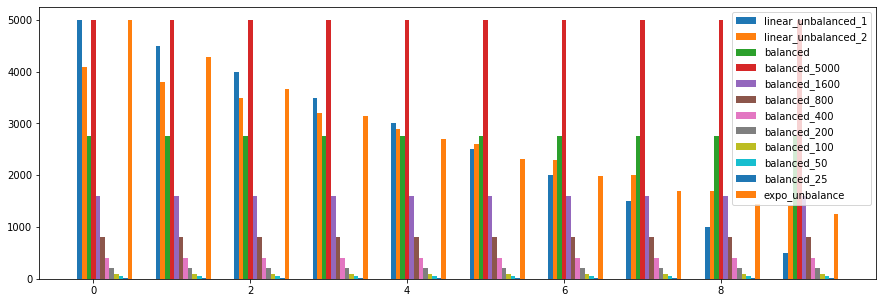

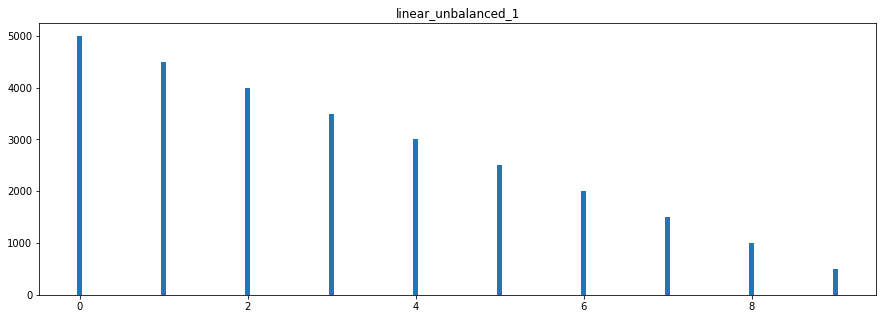

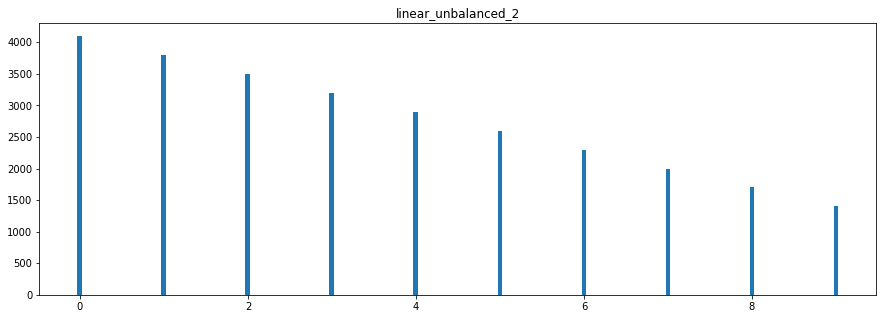

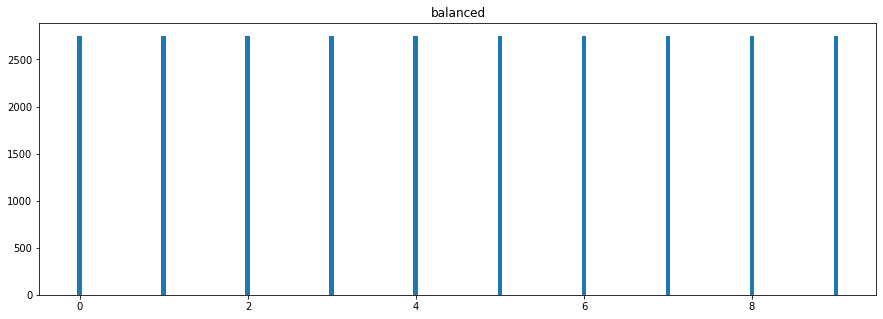

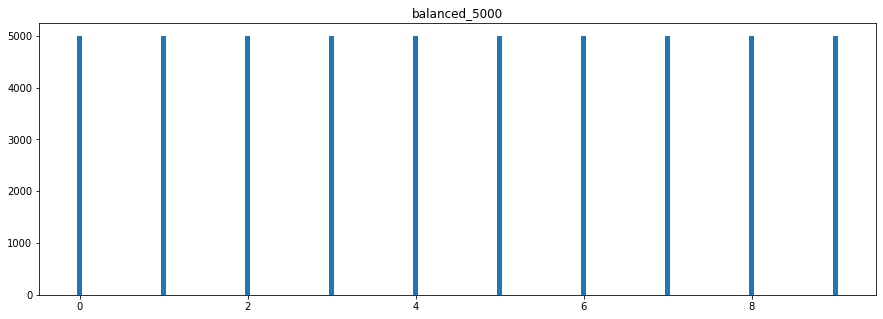

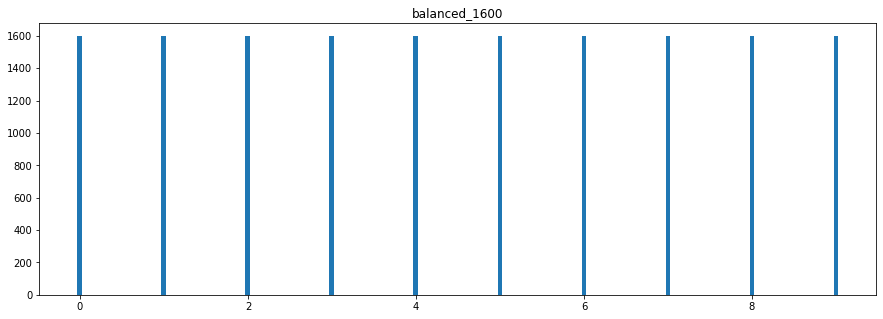

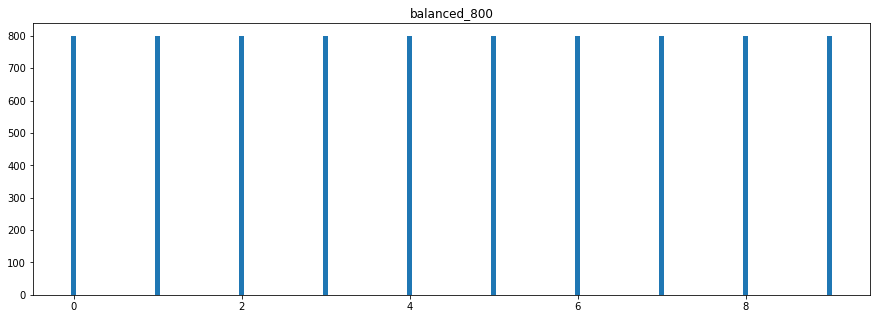

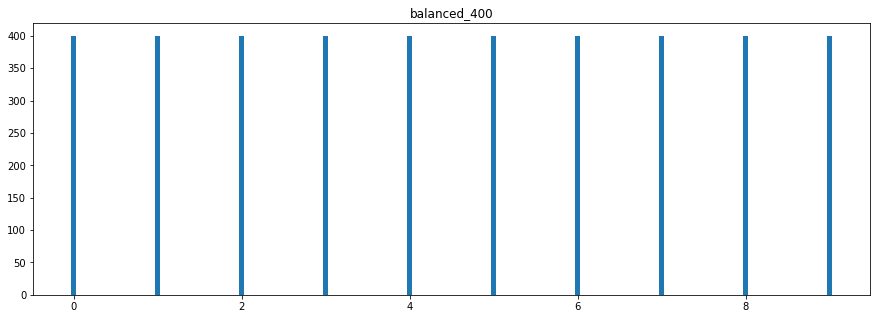

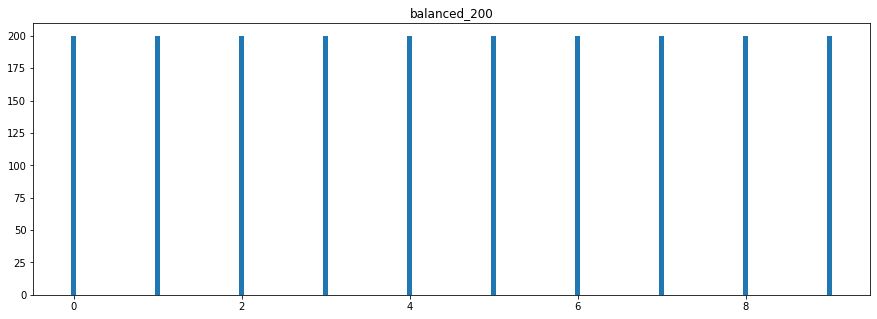

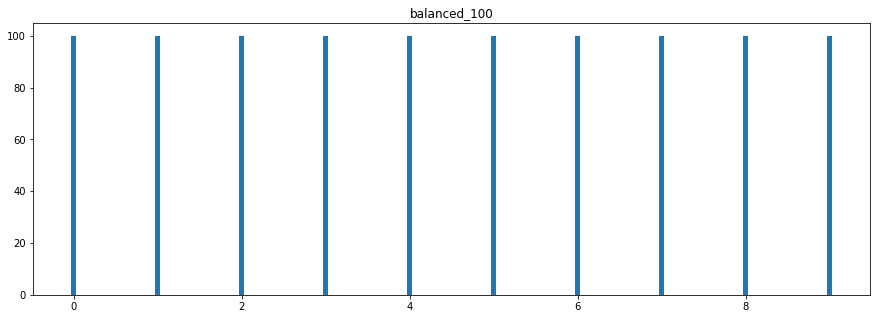

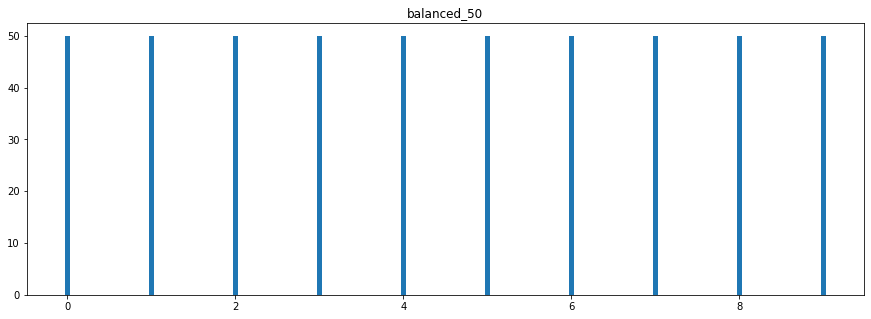

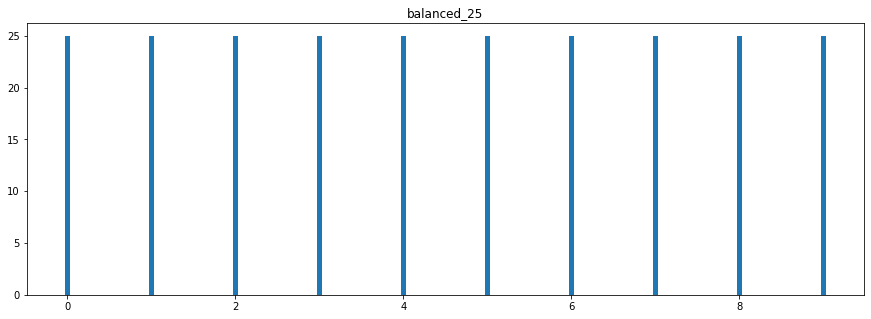

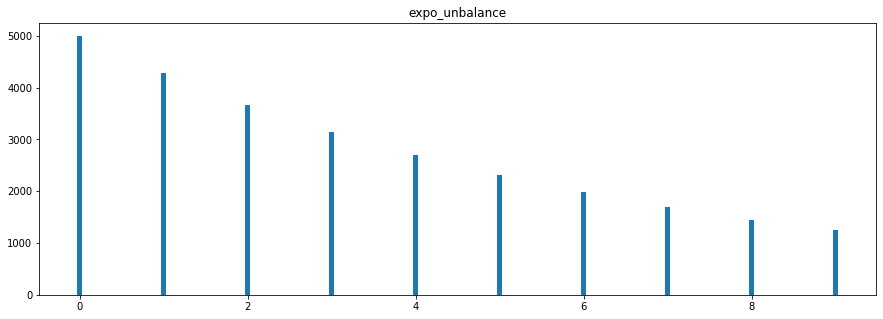

In [5]:
# new distributions

width = 0.7 / len(shapes)
x = np.arange(10) - len(shapes) * width / 4
i = 0

fig, ax = plt.subplots(figsize=(15, 5))
for shape in shapes:
    ax.bar(x + i*width, shape, width, label=names[i])
    i = i + 1
ax.legend()

i = 0
for shape in shapes:
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.bar(np.arange(10), shape, width)
    ax.set_title(names[i])
    i = i + 1


In [6]:
# get a random permutation for targets
permutation = np.array([9, 2, 3, 4, 7, 5, 0, 6, 8, 1])
np.array(list(range(5000,0,-500)))[permutation]

array([ 500, 4000, 3500, 3000, 1500, 2500, 5000, 2000, 1000, 4500])

In [9]:
# MNIST
MNIST = datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

In [10]:
# CIFAF10 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

CIFAR10 = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [11]:
# get indexs for each targets
MNIST_idx_dic = CustomDataset.produce_idx_dic(MNIST.targets)
CIFAR10_idx_dic = CustomDataset.produce_idx_dic(CIFAR10.targets)

In [15]:
# randomly select index and store as a npy file
randomState = np.random.RandomState(np.random.seed(12345))
for i in range(len(names)-2, len(names)-1):
    distribution = np.array(shapes[i])[permutation]
    MNIST_new_idx = CustomDataset.random_select(MNIST_idx_dic, distribution, randomState)
    CIFAR10_new_idx = CustomDataset.random_select(CIFAR10_idx_dic, distribution, randomState)
    
    np.save("./data/MNIST_"+names[i], MNIST_new_idx)
    np.save("./data/CIFAR10_"+names[i], CIFAR10_new_idx)
    

In [12]:
# finished